In [2]:
# Import libraries and dependencies

import pandas as pd 
from pathlib import Path
import numpy as np
from sklearn.linear_model import LinearRegression
import hvplot.pandas
import statsmodels.api as sm
from matplotlib import pyplot as plt

## 1. Reading in the Data

First, we will read in the Bitcoin data, using the date as the index. Our data comes from Gemini, a cryptocurrency exchange and trading venue. 

Our dataset contains the following information:
* Date/Time
* Ticker (BTC/USD, in this case)
* Open/High/Low/Close Price, for each hour from 2015-10-08 13:00:00 to 2022-10-11 00:00:00
* Volume traded, denominated in both BTC and USD

In [3]:
# Read in the data 
btc = pd.read_csv(Path('../Resources/Gemini_BTCUSD_1h.csv'),
                    skiprows=1,
                    index_col='date',
                    parse_dates=True,
                    infer_datetime_format=True)

#Display data
display(btc.head())
display(btc.tail())

,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2022-10-11 00:00:00,1665446400000,BTC/USD,19131.81,19131.81,18961.40,19005.03,52.075757,989701.319877
2022-10-10 23:00:00,1665442800000,BTC/USD,19139.83,19200.37,19127.76,19131.81,12.862135,246075.914596
2022-10-10 22:00:00,1665439200000,BTC/USD,19249.30,19252.80,19029.95,19139.83,48.738059,932838.156134
2022-10-10 21:00:00,1665435600000,BTC/USD,19247.16,19282.52,19222.32,19249.30,20.259358,389978.451480
2022-10-10 20:00:00,1665432000000,BTC/USD,19212.00,19256.80,19207.50,19247.16,15.592816,300117.430947


,unix,symbol,open,high,low,close,Volume BTC,Volume USD
date,,,,,,,,
2015-10-08 17:00:00,1444323600,BTC/USD,244.25,244.99,244.02,244.99,3.920632,960.515634
2015-10-08 16:00:00,1444320000,BTC/USD,244.92,244.92,244.25,244.25,3.895252,951.415413
2015-10-08 15:00:00,1444316400,BTC/USD,245.00,245.00,244.92,244.92,3.016926,738.905474
2015-10-08 14:00:00,1444312800,BTC/USD,245.00,245.00,244.50,245.00,4.453649,1091.143988
2015-10-08 13:00:00,1444309200,BTC/USD,0.00,245.00,0.00,245.00,0.606654,148.630323


## 2. Data Cleaning

Next, we will complete a number of steps to pre-process the data. This includes:

1. Removing all columns except date/time, closing price, and volume (USD).
2. Calculating hourly returns by calling the 'pct_change()' function
3. Removing hours where no trading occurred (see more details below)

In [4]:
#Remove all data except closing price and volume
btc_prices = btc[['close', 'Volume USD']]

# Reverse the order
btc_prices = btc_prices.sort_index(ascending=True)

display(btc_prices.head())

,close,Volume USD
date,,
2015-10-08 13:00:00,245.00,148.630323
2015-10-08 14:00:00,245.00,1091.143988
2015-10-08 15:00:00,244.92,738.905474
2015-10-08 16:00:00,244.25,951.415413
2015-10-08 17:00:00,244.99,960.515634


In [5]:
# Calculate hourly percent change (this will be the response variable)
btc_prices['hourly_returns'] = btc_prices['close'].pct_change().shift(-1)
btc_prices.head()

,close,Volume USD,hourly_returns
date,,,
2015-10-08 13:00:00,245.00,148.630323,0.000000
2015-10-08 14:00:00,245.00,1091.143988,-0.000327
2015-10-08 15:00:00,244.92,738.905474,-0.002736
2015-10-08 16:00:00,244.25,951.415413,0.003030
2015-10-08 17:00:00,244.99,960.515634,-0.004041


For our first regression, we need each row of the returns dataframe to have the following values (predictors):

1. The lagged hourly returns from hours t-1 through t-60
2. The current month
3. The current day
4. The current year

In [6]:
# Remove NA rows
btc_prices = btc_prices.dropna()

# Set date/month/year
btc_prices['year'] = btc_prices.index.year
btc_prices['month'] = btc_prices.index.month
btc_prices['day'] = btc_prices.index.day
display(btc_prices.head())

#Set date/month/year
btc_prices['year'] = btc_prices.index.year
btc_prices['month'] = btc_prices.index.month
btc_prices['day'] = btc_prices.index.day
display(btc_prices.head())

,close,Volume USD,hourly_returns,year,month,day
date,,,,,,
2015-10-08 13:00:00,245.00,148.630323,0.000000,2015,10,8
2015-10-08 14:00:00,245.00,1091.143988,-0.000327,2015,10,8
2015-10-08 15:00:00,244.92,738.905474,-0.002736,2015,10,8
2015-10-08 16:00:00,244.25,951.415413,0.003030,2015,10,8
2015-10-08 17:00:00,244.99,960.515634,-0.004041,2015,10,8


,close,Volume USD,hourly_returns,year,month,day
date,,,,,,
2015-10-08 13:00:00,245.00,148.630323,0.000000,2015,10,8
2015-10-08 14:00:00,245.00,1091.143988,-0.000327,2015,10,8
2015-10-08 15:00:00,244.92,738.905474,-0.002736,2015,10,8
2015-10-08 16:00:00,244.25,951.415413,0.003030,2015,10,8
2015-10-08 17:00:00,244.99,960.515634,-0.004041,2015,10,8


Notice that some of the hours had no trading volume. Looking at how this data varies by year, it becomes clear that almost all of the "zero-volume days" happened before 2016. It seems likely that before the increased popularity of cryptocurrencies, when trading volume was limited, there were more discrepancies in the hourly data. Another explanation is cases where the exchange halted trading for extended periods. In light of this, we will remove these items from the dataset and any rows that reference these rows.

In [7]:
sum(btc_prices['Volume USD'] == 0)
zero_vol = btc_prices[btc_prices['Volume USD'] == 0]

display(zero_vol.groupby('year').count())

,close,Volume USD,hourly_returns,month,day
year,,,,,
2015,353,353,353,353,353
2016,552,552,552,552,552
2017,86,86,86,86,86
2018,52,52,52,52,52
2019,42,42,42,42,42
2020,24,24,24,24,24
2021,13,13,13,13,13
2022,4,4,4,4,4


In [8]:
# Add Nan values to rows with no volume 
btc_prices['hourly_returns'] = np.where(btc_prices['Volume USD'] == 0, np.nan, btc_prices['hourly_returns'])

In [9]:
# Calculate lagged hourly returns 
for i in range(1, 60):
    btc_prices[f'lag{i}'] = btc_prices['hourly_returns'].shift(i)

In [10]:
# Remove values that reference hours with zero volume
btc_prices = btc_prices.dropna()

## 3. Modeling

This is where things start to get interesting. Here, we will train a multiple regression model predicting $R_{t, t+1}$, the hourly return from hour $t$ to $t+1$ with each of $\{R_{t-i, t-i+1} | i \in [1, 60]\}$ and an intercept. Then, we will graph the confidence intervals for each of the $R_{t-i, t-i+1}$ to see which lagged hourly returns have the most significant effect on the next hour of returns.

In [11]:
#### Do the model
X = btc_prices.filter(regex='lag|year|month|day')
X = sm.add_constant(X)
Y = btc_prices['hourly_returns']


btc_model = sm.OLS(Y, X).fit()
print(btc_model.summary())

                            OLS Regression Results                            
Dep. Variable:         hourly_returns   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.200
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           8.65e-48
Time:                        21:04:19   Log-Likelihood:             1.5395e+05
No. Observations:               46777   AIC:                        -3.078e+05
Df Residuals:                   46714   BIC:                        -3.072e+05
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0647      0.048      1.358      0.1

Given that the day, month, and year effects are not significant predictors. We will remove them from the regression and re-run it, this time only with the lagged returns as predictors.


In [12]:
#### Do the model pt. 2
X = btc_prices.filter(regex='lag')
X = sm.add_constant(X)
Y = btc_prices['hourly_returns']


btc_model = sm.OLS(Y, X).fit()
print(btc_model.summary())

                            OLS Regression Results                            
Dep. Variable:         hourly_returns   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     6.483
Date:                Tue, 18 Oct 2022   Prob (F-statistic):           1.18e-48
Time:                        21:04:19   Log-Likelihood:             1.5395e+05
No. Observations:               46777   AIC:                        -3.078e+05
Df Residuals:                   46717   BIC:                        -3.073e+05
Df Model:                          59                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.796e-05   4.18e-05      2.341      0.0

In [13]:
# Get confidence intervals for parameters
param_err = btc_model.params - btc_model.conf_int()[0]

# Set up coefficient dataframe
coef_df = pd.DataFrame({'coef': btc_model.params.values[1:],
                        'err': param_err.values[1:],
                        'varname': param_err.index.values[1:]
                          })

# View coefficients
display(coef_df.head())

,coef,err,varname
0,-0.044077,0.009058,lag1
1,-0.027771,0.009063,lag2
2,-0.011988,0.009115,lag3
3,-0.000540,0.009140,lag4
4,-0.014087,0.009146,lag5


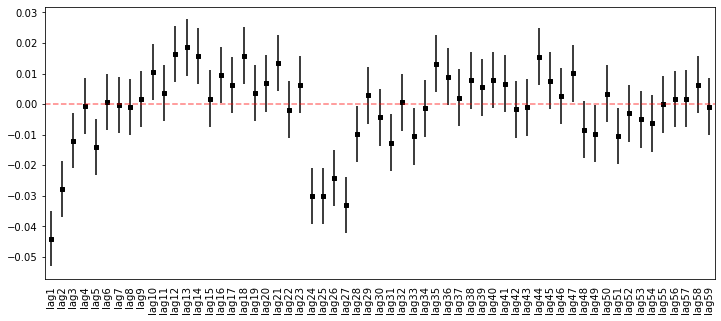

In [14]:
#Create plot figure
fig, ax = plt.subplots(figsize=(12, 5))

#Plot the conf. int
coef_df.plot(x='varname', y='coef', kind='bar', ax=ax,
             yerr='err', legend=False, color='none',
             xlabel='')

#Add the means
ax.scatter(x=np.arange(coef_df.shape[0]),
           marker='s', s=20,
           y=coef_df['coef'], color='black')

#Add zero line
ax.axhline(y=0, color='red', linestyle='--', alpha=.5)
ax.xaxis.set_ticks_position('none')

A few things stand out to us about the above graph and the results of our regression:

* As expected, our results matched the results of the paper we attempted to replicate.
* The effect of the closest lagged returns (hours 1-3, 5) was significant (~1-5 bps). These effects are likely due to features of the market microstructure on Gemini. 
* There are significant positive effects for hours 10, 12, 13, 14, 16, 18, and 21. 
* There are highly significant negative effects for hours 24-27 of about equal size (~2-4bps). Interestingly, there is a stark start/end to this trend after hour 23/before hour 28. 
* The same pattern appears to hold, but to a lesser extent, for the next 24 hours of lagged returns.